In [1]:
import pandas as pd
import os

In [2]:
root_folder = "art500k_period"

data = []

for folder in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".jpg"):
                file_path = os.path.join(folder_path, file)
                data.append((file_path, float(folder)))

df = pd.DataFrame(data, columns=["Full_Path", "Period_Label"])

# drop periods 0 and 6
df = df[(df["Period_Label"] != 0.0) & (df["Period_Label"] != 6.0)]
df["Period_Label"] -= 1.0

df.head()

,Full_Path,Period_Label
0,art500k_period/1.0/823.jpg,0.0
1,art500k_period/1.0/16750.jpg,0.0
2,art500k_period/1.0/16988.jpg,0.0
3,art500k_period/1.0/The Ascension##dQE3OyMRBV0s...,0.0
4,art500k_period/1.0/32180.jpg,0.0


In [3]:
period_labels = df["Period_Label"].unique()

In [4]:
label_counts = df["Period_Label"].value_counts().sort_index()
label_counts

Period_Label
0.0     3066
1.0    16077
2.0     9939
3.0     6247
4.0     6802
Name: count, dtype: int64

In [5]:
import torch
from sklearn.model_selection import train_test_split

# drop nans
df = df.dropna(subset=["Period_Label"]).reset_index(drop=True)

# convert period label to int
df["Period_Label"] = df["Period_Label"].astype(int)

# 80/20 treain test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Period_Label"], random_state=42)

# Convert to tensors
train_labels = torch.tensor(train_df["Period_Label"].values, dtype=torch.long)
test_labels = torch.tensor(test_df["Period_Label"].values, dtype=torch.long)

print(df)


                                               Full_Path  Period_Label
0                             art500k_period/1.0/823.jpg             0
1                           art500k_period/1.0/16750.jpg             0
2                           art500k_period/1.0/16988.jpg             0
3      art500k_period/1.0/The Ascension##dQE3OyMRBV0s...             0
4                           art500k_period/1.0/32180.jpg             0
...                                                  ...           ...
42126  art500k_period/4.0/Ten Panel Folding Screen Of...             3
42127  art500k_period/4.0/Perseus Confronting Phineus...             3
42128                        art500k_period/4.0/8434.jpg             3
42129                       art500k_period/4.0/35190.jpg             3
42130                       art500k_period/4.0/42318.jpg             3

[42131 rows x 2 columns]


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def preprocess_image(self, image_path, target_size=(224, 224)):
    # Preprocess the image (resize and normalize)
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (only one batch)
    img_array = img_array / 255.0  # Normalize image
    return img_array
    
# mult-class classification
model = Sequential([
    # first layer w padding
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),  #resize images
    MaxPooling2D((2, 2)),  # max pooling

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # max pooling

    Flatten(),

    # fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.7),  
    Dense(64, activation='relu'), 
    Dropout(0.7),  

    # output layer
    Dense(len(period_labels), activation='softmax')  # Output layer (one neuron per class)
])
'''
# Simplified CNN model for multi-class classification
model = Sequential([
    # First convolutional layer with padding
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),  # Resize images to 224x224x3
    MaxPooling2D((2, 2)),  # Max pooling

    # Flatten
    Flatten(),

    # Output layer for multi-class classification
    Dense(len(period_labels), activation='softmax')  # Output layer (one neuron per class)
])
'''
# compile model
#using learning rate of 0.0001 adam
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model summary
model.summary()



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 193600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    24,780,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,808,901 (94.64 MB)

 Trainable params: 24,808,901 (94.64 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#attempt 2 w generators

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
image_size = (224, 224)  # Target size for images
image_folder = "/art500k"  # Folder containing images
batch_size = 32  # Batch size for training

# # Create a DataFrame with image paths and labels
# df['Full_Path'] = image_folder + "/" + df['path']

# # Function to check and remove corrupt images
# def filter_valid_images(df):
#     valid_files = []
#     for path in df["Full_Path"]:
#         try:
#             img = load_img(path)  # Try loading the image
#             img.verify()  # Verify it's not corrupt
#             valid_files.append(path)
#         except (UnidentifiedImageError, OSError, FileNotFoundError):
#             #print(f"Skipping corrupt/missing file: {path}")  # Log skipped files
#             continue  # Skip the corrupt file
#     return df[df["Full_Path"].isin(valid_files)]  # Keep only valid images

# # Remove corrupt images before splitting data
# df = filter_valid_images(df)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Full_Path',
    y_col='Period_Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'  # Use 'raw' for regression or integer labels
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Full_Path',
    y_col='Period_Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

# Train the model
model.fit(train_generator, epochs=10, validation_data=test_generator)


Found 33704 validated image filenames.
Found 8427 validated image filenames.
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1054/1054 ━━━━━━━━━━━━━━━━━━━━ 590s 558ms/step - accuracy: 0.3649 - loss: 1.6633 - val_accuracy: 0.3751 - val_loss: 1.4760
Epoch 2/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1126s 1s/step - accuracy: 0.3832 - loss: 1.4600 - val_accuracy: 0.3751 - val_loss: 1.4460
Epoch 3/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1478s 1s/step - accuracy: 0.3921 - loss: 1.4235 - val_accuracy: 0.4036 - val_loss: 1.4177
Epoch 4/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1407s 1s/step - accuracy: 0.4243 - loss: 1.3751 - val_accuracy: 0.4304 - val_loss: 1.3532
Epoch 5/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 5123s 5s/step - accuracy: 0.4608 - loss: 1.2961 - val_accuracy: 0.4375 - val_loss: 1.3336
Epoch 6/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1332s 1s/step - accuracy: 0.5100 - loss: 1.1964 - val_accuracy: 0.4399 - val_loss: 1.3773
Epoch 7/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1334s 1s/step - accuracy: 0.5429 - loss: 1.1271 - val_accuracy: 0.4497 - val_loss: 1.4059
Epoch 8/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1337s 1s/step - accuracy: 0.5833 - loss: 1.

In [8]:
#showing predictions

import numpy as np
import pandas as pd

# Step 1: Get predictions for the test set
y_pred_prob = model.predict(test_generator)  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Step 2: Get the actual labels from the test generator
# Reset the generator to ensure we get all the data in order
test_generator.reset()
y_true = test_generator.labels  # Actual labels

# Step 3: Get the image paths from the test generator
image_paths = test_generator.filenames

# Step 4: Create a DataFrame with the results
results_df = pd.DataFrame({
    'Image_Path': image_paths,
    'Actual': y_true,
    'Predicted': y_pred
})

# Step 5: Add a column to check if the prediction was correct
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

# Print the DataFrame
print(results_df)

# Step 6: Evaluate the model's performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\nAccuracy:", accuracy_score(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

264/264 ━━━━━━━━━━━━━━━━━━━━ 113s 427ms/step
                                             Image_Path  Actual  Predicted  \
0                          art500k_period/5.0/25406.jpg       4          2   
1                          art500k_period/2.0/36237.jpg       1          3   
2                          art500k_period/2.0/33124.jpg       1          3   
3          art500k_period/4.0/Diana##EQHFgkIepFNu3Q.jpg       3          1   
4                          art500k_period/3.0/36566.jpg       2          1   
...                                                 ...     ...        ...   
8422  art500k_period/2.0/Study Of A Pleated Skirt##k...       1          2   
8423                       art500k_period/3.0/24487.jpg       2          1   
8424                        art500k_period/3.0/5347.jpg       2          3   
8425                       art500k_period/5.0/41600.jpg       4          1   
8426                       art500k_period/4.0/35223.jpg       3          2   

      Correct  
0 

Actual Distribution:
 Actual
0     648
1    3161
2    1956
3    1259
4    1403
Name: count, dtype: int64

Predicted Distribution:
 Predicted
0      22
1    4861
2    2153
3     740
4     651
Name: count, dtype: int64


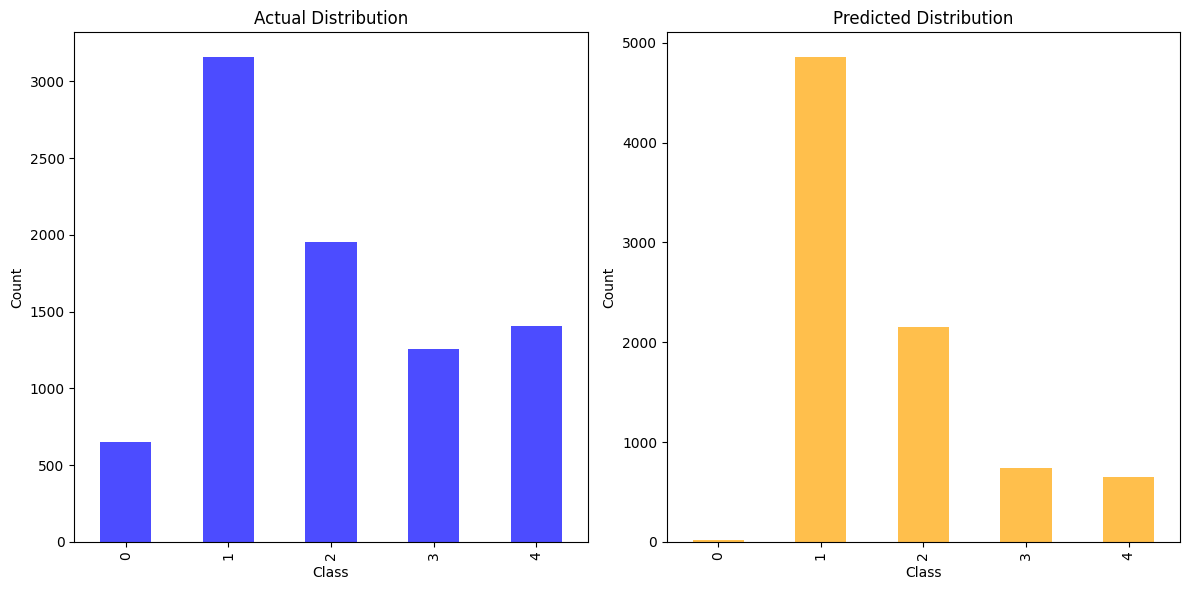

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the results_df DataFrame
# results_df contains columns: 'Image_Path', 'Actual', 'Predicted', 'Correct'

# Step 1: Get the distribution of actual labels
actual_distribution = results_df['Actual'].value_counts().sort_index()
print("Actual Distribution:\n", actual_distribution)

# Step 2: Get the distribution of predicted labels
predicted_distribution = results_df['Predicted'].value_counts().sort_index()
print("\nPredicted Distribution:\n", predicted_distribution)

# Step 3: Plot the distributions
plt.figure(figsize=(12, 6))

# Plot actual distribution
plt.subplot(1, 2, 1)
actual_distribution.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Actual Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Plot predicted distribution
plt.subplot(1, 2, 2)
predicted_distribution.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Predicted Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()